In [ ]:
#Starting code for PatRec project
#   Omada 2 -- Grokfast experiments

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# from google.colab import files
# files.upload()


In [ ]:
!ls /content/drive/MyDrive/PatRec_Project_Shared_Folder/

Algorithmic_code  MNIST_code	  __pycache__  requirements.txt  results2_test_random_seed_12
grokfast.py	  _Presentations  QM9_code     results


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/PatRec_Project_Shared_Folder')

In [ ]:
!pip install -r /content/drive/MyDrive/PatRec_Project_Shared_Folder/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [ ]:
import math
from argparse import ArgumentParser
from itertools import permutations
import copy

import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from grokfast import gradfilter_ma, gradfilter_ema, gradfilter_with_depth_scaling

In [ ]:

class Block(nn.Module):
    """Causal transformer block
    """

    def __init__(self, dim, num_heads):
        super().__init__()
        self.ln_1 = nn.LayerNorm(dim)
        self.ln_2 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim),
        )

    def forward(self, x):
        attn_mask = torch.full(
            (len(x), len(x)), -float("Inf"), device=x.device, dtype=x.dtype
        )
        attn_mask = torch.triu(attn_mask, diagonal=1)
        attn_mask[torch.isnan(attn_mask)] = 0.0 # fixes all 'nan' on 'mps' device

        x = self.ln_1(x)
        a, _ = self.attn(x, x, x, attn_mask=attn_mask, need_weights=False)
        x = x + a
        m = self.mlp(self.ln_2(x))
        x = x + m
        return x


class Decoder(nn.Module):
    """Causal Transformer decoder
    """

    def __init__(self, dim=128, num_layers=2, num_heads=4, num_tokens=97, seq_len=5):
        super().__init__()
        self.token_embeddings = nn.Embedding(num_tokens, dim)
        self.position_embeddings = nn.Embedding(seq_len, dim)
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(Block(dim, num_heads))

        self.ln_f = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, num_tokens, bias=False)

    def forward(self, x):
        h = self.token_embeddings(x)
        positions = torch.arange(x.shape[0], device=x.device).unsqueeze(-1)
        h = h + self.position_embeddings(positions).expand_as(h)
        for layer in self.layers:
            h = layer(h)

        h = self.ln_f(h)
        logits = self.head(h)
        return logits




In [ ]:
def multiplication_mod_p_data(p, eq_token, op_token):
    """x◦y = x/y (mod p) for 0 ≤ x < p, 0 < y < p
    """
    x = torch.arange(p)
    y = torch.arange(1, p)
    x, y = torch.cartesian_prod(x, y).T

    eq = torch.ones_like(x) * eq_token
    op = torch.ones_like(x) * op_token
    result = x * y % p

    # "All of our experiments used a small transformer trained on datasets of
    # equations of the form a◦b = c, where each of “a”, “◦”, “b”, “=”, and “c”
    # is a seperate token"
    return torch.stack([x, op, y, eq, result])



In [ ]:
import os

# Specify the path to save in Google Drive
results_dir = "/content/drive/MyDrive/PatRec_Project_Shared_Folder/results"
os.makedirs(results_dir, exist_ok=True)

In [ ]:
def main(args):
    torch.manual_seed(args.seed)


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # tokens for <op> and <=>. It's not clear why <=> is needed at all since it
    # has no effect on the output, but we'll leave it in to best follow the
    # paper.
    eq_token = args.p
    op_token = args.p + 1

    # "We trained a standard decoder-only transformer (Vaswani et al., 2017)
    # with causal attention masking, and calculated loss and accuracy only on
    # the answer part of the equation. For all experiments we used a
    # transformer with 2 layers, width 128, and 4 attention heads"
    model = Decoder(
        dim=128, num_layers=2, num_heads=4, num_tokens=args.p + 2, seq_len=5
    ).to(device)
    nparams = sum([p.numel() for p in model.parameters() if p.requires_grad])
    print(model)
    print(f'Total number of parameters: {nparams}')

    data = multiplication_mod_p_data(args.p, eq_token, op_token)

    # Split the subset into training and validation sets
    split_idx = data.shape[1] // 2
    perm = torch.randperm(data.shape[1])
    train_idx = perm[:split_idx]
    valid_idx = perm[split_idx:]
    train_data = data[:, train_idx]
    valid_data = data[:, valid_idx]

    # For most experiments we used AdamW optimizer with learning rate 10−3,
    # weight decay 1, β1 = 0.9, β2 = 0.98
    optimizer = getattr(torch.optim, args.optimizer)(
        model.parameters(),
        lr=args.lr,
        weight_decay=args.weight_decay,
        betas=(args.beta1, args.beta2),
    )

    #  linear learning rate warmup over the first 10 updates
    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer, lambda update: 1 if update > 10 else update / 10
    )

    steps_per_epoch = math.ceil(train_data.shape[1] / args.batch_size)

    its, train_acc, val_acc, train_loss, val_loss = [], [], [], [], []
    grads = None
    i = 0

    # For logging network weights.
    net_its, nets = [], []

    for e in tqdm(range(int(args.budget) // steps_per_epoch)):

        # randomly shuffle train data
        train_data = train_data[:, torch.randperm(train_data.shape[1])]

        for data, is_train in [(train_data, True), (valid_data, False)]:

            model.train(is_train)
            total_loss = 0
            total_acc = 0

            # torch.split faster than dataloader with tensor
            dl = torch.split(data, args.batch_size, dim=1)
            for input in dl:
                input = input.to(device)


                with torch.set_grad_enabled(is_train):
                    logits = model(input[:-1])
                    # calculate loss only on the answer part of the equation (last element
                    loss = F.cross_entropy(logits[-1], input[-1])
                    total_loss += loss.item() * input.shape[-1]

                if is_train:
                    model.zero_grad()
                    loss.backward()

                    #######

                    trigger = i < 500 if args.two_stage else False

                    if args.filter == "none":
                        pass
                    elif args.filter == "ma":
                        grads = gradfilter_ma(model, grads=grads, window_size=args.window_size, lamb=args.lamb, trigger=trigger)
                    elif args.filter == "ema":
                        grads = gradfilter_ema(model, grads=grads, alpha=args.alpha, lamb=args.lamb)
                    else:
                        raise ValueError(f"Invalid gradient filter type `{args.filter}`")

                    #######

                    optimizer.step()
                    scheduler.step()
                    i += 1

                acc = (logits[-1].argmax(-1) == input[-1]).float().mean()
                total_acc += acc.item() * input.shape[-1]

            if is_train:
                train_acc.append(total_acc / train_data.shape[-1])
                train_loss.append(total_loss / train_data.shape[-1])
                its.append(i)
            else:
                val_acc.append(total_acc / valid_data.shape[-1])
                val_loss.append(total_loss / valid_data.shape[-1])

        if args.save_weights:
            do_save = e <= 500 or (e > 500 and (e + 1) % 100 == 0) or e == int(args.budget) // steps_per_epoch - 1
        else:
            do_save = (e + 1) % 100 == 0
        if do_save:
            steps = torch.arange(len(train_acc)).numpy() * steps_per_epoch
            plt.plot(steps, train_acc, label="train")
            plt.plot(steps, val_acc, label="val")
            plt.legend()
            plt.title("Modular Multiplication (training on 50% of data)")
            plt.xlabel("Optimization Steps")
            plt.ylabel("Accuracy")
            plt.xscale("log", base=10)
            plt.grid()
            plt.savefig(f"{results_dir}/acc_{args.label}.png", dpi=150)
            plt.close()

            plt.plot(steps, train_loss, label="train")
            plt.plot(steps, val_loss, label="val")
            plt.legend()
            plt.title("Modular Multiplication (training on 50% of data)")
            plt.xlabel("Optimization Steps")
            plt.ylabel("Loss")
            plt.xscale("log", base=10)
            plt.grid()
            plt.savefig(f"{results_dir}/loss_{args.label}.png", dpi=150)
            plt.close()

            results = {
                'its': its,
                'train_acc': train_acc,
                'train_loss': train_loss,
                'val_acc': val_acc,
                'val_loss': val_loss,
            }

            if args.save_weights:
                net_its.append(e)
                nets.append(copy.deepcopy(model.state_dict()))
                results['net_its'] = net_its
                results['net'] = nets

            torch.save(results, f"{results_dir}/res_{args.label}.pt")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
if __name__ == "__main__":
    parser = ArgumentParser()
    parser.add_argument("--label", default="")
    parser.add_argument("--seed", type=int, default=0)
    parser.add_argument("--p", type=int, default=97)
    parser.add_argument("--budget", type=int, default=3e5)
    parser.add_argument("--batch_size", type=int, default=256)
    parser.add_argument("--lr", type=float, default=1e-3)
    parser.add_argument("--beta1", type=float, default=0.9)
    parser.add_argument("--beta2", type=float, default=0.98)
    parser.add_argument("--weight_decay", type=float, default=0)
    parser.add_argument("--optimizer", default="Adam")
    parser.add_argument("--filter", type=str, choices=["none", "ma", "ema", "fir"], default="none")
    parser.add_argument("--alpha", type=float, default=0.99)
    parser.add_argument("--window_size", type=int, default=50)
    parser.add_argument("--lamb", type=float, default=5.0)
    parser.add_argument("--two_stage", action='store_true')
    parser.add_argument("--save_weights", action='store_true')
    parser.add_argument("--dataset_fraction", type=float, default=1.0, help="Fraction of the dataset to use (0.0 to 1.0)")


    # Parse known arguments to handle Jupyter conflicts
    args, unknown = parser.parse_known_args()

    # Modify label dynamically
    filter_str = ('_' if args.label != '' else '') + args.filter
    window_size_str = f'_w{args.window_size}'
    alpha_str = f'_a{args.alpha:.3f}'.replace('.', '')
    lamb_str = f'_l{int(args.lamb)}'

    if args.filter == "none":
        filter_suffix = ""
    elif args.filter == "ma":
        filter_suffix = window_size_str + lamb_str
    elif args.filter == "ema":
        filter_suffix = alpha_str + lamb_str
    else:
        raise ValueError(f"Unrecognized filter type {args.filter}")

    optim_suffix = ""
    if args.weight_decay != 0:
        optim_suffix = optim_suffix + f'_wd{args.weight_decay:.1e}'.replace('.', '')
    if args.lr != 1e-3:
        optim_suffix = optim_suffix + f'_lrx{int(args.lr / 1e-3)}'

    args.label = args.label + filter_str + filter_suffix + optim_suffix
    print(f"Experiment results saved under name: {args.label}")

    print(f"Dataset size: {args.dataset_fraction}")


   # Call main
    main(args)


Experiment results saved under name: none
Dataset size: 1.0
Decoder(
  (token_embeddings): Embedding(99, 128)
  (position_embeddings): Embedding(5, 128)
  (layers): ModuleList(
    (0-1): 2 x Block(
      (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ln_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=512, out_features=128, bias=True)
      )
    )
  )
  (ln_f): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=128, out_features=99, bias=False)
)
Total number of parameters: 422784


  0%|          | 7/15789 [00:10<6:36:07,  1.51s/it]


KeyboardInterrupt: 

In [ ]:
#Running EMA algoritmh with window=20 below

In [ ]:
if __name__ == "__main__":
    parser = ArgumentParser()
    parser.add_argument("--label", default="")
    parser.add_argument("--seed", type=int, default=0)
    parser.add_argument("--p", type=int, default=97)
    parser.add_argument("--budget", type=int, default=3e5)
    parser.add_argument("--batch_size", type=int, default=256)
    parser.add_argument("--lr", type=float, default=1e-3)
    parser.add_argument("--beta1", type=float, default=0.9)
    parser.add_argument("--beta2", type=float, default=0.98)
    parser.add_argument("--weight_decay", type=float, default=0.0001)
    parser.add_argument("--optimizer", default="Adam")
    parser.add_argument("--filter", type=str, choices=["none", "ma", "ema", "fir"], default="none")
    parser.add_argument("--alpha", type=float, default=0.99)
    parser.add_argument("--window_size", type=int, default=50)
    parser.add_argument("--lamb", type=float, default=5.0)
    parser.add_argument("--two_stage", action='store_true')
    parser.add_argument("--save_weights", action='store_true')
    parser.add_argument("--dataset_fraction", type=float, default=1.0, help="Fraction of the dataset to use (0.0 to 1.0)")


    # Parse known arguments to handle Jupyter conflicts
    args, unknown = parser.parse_known_args()

    # Modify label dynamically
    filter_str = ('_' if args.label != '' else '') + args.filter
    window_size_str = f'_w{args.window_size}'
    alpha_str = f'_a{args.alpha:.3f}'.replace('.', '')
    lamb_str = f'_l{int(args.lamb)}'

    if args.filter == "none":
        filter_suffix = ""
    elif args.filter == "ma":
        filter_suffix = window_size_str + lamb_str
    elif args.filter == "ema":
        filter_suffix = alpha_str + lamb_str
    else:
        raise ValueError(f"Unrecognized filter type {args.filter}")

    optim_suffix = ""
    if args.weight_decay != 0:
        optim_suffix = optim_suffix + f'_wd{args.weight_decay:.1e}'.replace('.', '')
    if args.lr != 1e-3:
        optim_suffix = optim_suffix + f'_lrx{int(args.lr / 1e-3)}'

    args.label = args.label + filter_str + filter_suffix + optim_suffix
    print(f"Experiment results saved under name: {args.label}")

    print(f"Dataset size: {args.dataset_fraction}")


   # Call main
    main(args)


Experiment results saved under name: none_wd10e-04
Dataset size: 1.0
Decoder(
  (token_embeddings): Embedding(99, 128)
  (position_embeddings): Embedding(5, 128)
  (layers): ModuleList(
    (0-1): 2 x Block(
      (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ln_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=512, out_features=128, bias=True)
      )
    )
  )
  (ln_f): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=128, out_features=99, bias=False)
)
Total number of parameters: 422784


100%|██████████| 15789/15789 [42:59<00:00,  6.12it/s]


In [ ]:
if __name__ == "__main__":
    parser = ArgumentParser()
    parser.add_argument("--label", default="")
    parser.add_argument("--seed", type=int, default=0)
    parser.add_argument("--p", type=int, default=97)
    parser.add_argument("--budget", type=int, default=3e5)
    parser.add_argument("--batch_size", type=int, default=256)
    parser.add_argument("--lr", type=float, default=1e-3)
    parser.add_argument("--beta1", type=float, default=0.9)
    parser.add_argument("--beta2", type=float, default=0.98)
    parser.add_argument("--weight_decay", type=float, default=0.0005)
    parser.add_argument("--optimizer", default="Adam")
    parser.add_argument("--filter", type=str, choices=["none", "ma", "ema", "fir"], default="none")
    parser.add_argument("--alpha", type=float, default=0.99)
    parser.add_argument("--window_size", type=int, default=50)
    parser.add_argument("--lamb", type=float, default=5.0)
    parser.add_argument("--two_stage", action='store_true')
    parser.add_argument("--save_weights", action='store_true')
    parser.add_argument("--dataset_fraction", type=float, default=1.0, help="Fraction of the dataset to use (0.0 to 1.0)")


    # Parse known arguments to handle Jupyter conflicts
    args, unknown = parser.parse_known_args()

    # Modify label dynamically
    filter_str = ('_' if args.label != '' else '') + args.filter
    window_size_str = f'_w{args.window_size}'
    alpha_str = f'_a{args.alpha:.3f}'.replace('.', '')
    lamb_str = f'_l{int(args.lamb)}'

    if args.filter == "none":
        filter_suffix = ""
    elif args.filter == "ma":
        filter_suffix = window_size_str + lamb_str
    elif args.filter == "ema":
        filter_suffix = alpha_str + lamb_str
    else:
        raise ValueError(f"Unrecognized filter type {args.filter}")

    optim_suffix = ""
    if args.weight_decay != 0:
        optim_suffix = optim_suffix + f'_wd{args.weight_decay:.1e}'.replace('.', '')
    if args.lr != 1e-3:
        optim_suffix = optim_suffix + f'_lrx{int(args.lr / 1e-3)}'

    args.label = args.label + filter_str + filter_suffix + optim_suffix
    print(f"Experiment results saved under name: {args.label}")

    print(f"Dataset size: {args.dataset_fraction}")


   # Call main
    main(args)


Experiment results saved under name: none_wd50e-04
Dataset size: 1.0
Decoder(
  (token_embeddings): Embedding(99, 128)
  (position_embeddings): Embedding(5, 128)
  (layers): ModuleList(
    (0-1): 2 x Block(
      (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ln_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=512, out_features=128, bias=True)
      )
    )
  )
  (ln_f): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=128, out_features=99, bias=False)
)
Total number of parameters: 422784


100%|██████████| 15789/15789 [43:20<00:00,  6.07it/s]


In [ ]:
if __name__ == "__main__":
    parser = ArgumentParser()
    parser.add_argument("--label", default="")
    parser.add_argument("--seed", type=int, default=0)
    parser.add_argument("--p", type=int, default=97)
    parser.add_argument("--budget", type=int, default=3e5)
    parser.add_argument("--batch_size", type=int, default=256)
    parser.add_argument("--lr", type=float, default=1e-3)
    parser.add_argument("--beta1", type=float, default=0.9)
    parser.add_argument("--beta2", type=float, default=0.98)
    parser.add_argument("--weight_decay", type=float, default=0.001)
    parser.add_argument("--optimizer", default="Adam")
    parser.add_argument("--filter", type=str, choices=["none", "ma", "ema", "fir"], default="none")
    parser.add_argument("--alpha", type=float, default=0.99)
    parser.add_argument("--window_size", type=int, default=50)
    parser.add_argument("--lamb", type=float, default=5.0)
    parser.add_argument("--two_stage", action='store_true')
    parser.add_argument("--save_weights", action='store_true')
    parser.add_argument("--dataset_fraction", type=float, default=1.0, help="Fraction of the dataset to use (0.0 to 1.0)")


    # Parse known arguments to handle Jupyter conflicts
    args, unknown = parser.parse_known_args()

    # Modify label dynamically
    filter_str = ('_' if args.label != '' else '') + args.filter
    window_size_str = f'_w{args.window_size}'
    alpha_str = f'_a{args.alpha:.3f}'.replace('.', '')
    lamb_str = f'_l{int(args.lamb)}'

    if args.filter == "none":
        filter_suffix = ""
    elif args.filter == "ma":
        filter_suffix = window_size_str + lamb_str
    elif args.filter == "ema":
        filter_suffix = alpha_str + lamb_str
    else:
        raise ValueError(f"Unrecognized filter type {args.filter}")

    optim_suffix = ""
    if args.weight_decay != 0:
        optim_suffix = optim_suffix + f'_wd{args.weight_decay:.1e}'.replace('.', '')
    if args.lr != 1e-3:
        optim_suffix = optim_suffix + f'_lrx{int(args.lr / 1e-3)}'

    args.label = args.label + filter_str + filter_suffix + optim_suffix
    print(f"Experiment results saved under name: {args.label}")

    print(f"Dataset size: {args.dataset_fraction}")


   # Call main
    main(args)


Experiment results saved under name: none_wd10e-03
Dataset size: 1.0
Decoder(
  (token_embeddings): Embedding(99, 128)
  (position_embeddings): Embedding(5, 128)
  (layers): ModuleList(
    (0-1): 2 x Block(
      (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ln_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=512, out_features=128, bias=True)
      )
    )
  )
  (ln_f): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=128, out_features=99, bias=False)
)
Total number of parameters: 422784


100%|██████████| 15789/15789 [42:52<00:00,  6.14it/s]


In [ ]:
if __name__ == "__main__":
    parser = ArgumentParser()
    parser.add_argument("--label", default="")
    parser.add_argument("--seed", type=int, default=0)
    parser.add_argument("--p", type=int, default=97)
    parser.add_argument("--budget", type=int, default=3e5)
    parser.add_argument("--batch_size", type=int, default=256)
    parser.add_argument("--lr", type=float, default=1e-3)
    parser.add_argument("--beta1", type=float, default=0.9)
    parser.add_argument("--beta2", type=float, default=0.98)
    parser.add_argument("--weight_decay", type=float, default=0.01)
    parser.add_argument("--optimizer", default="Adam")
    parser.add_argument("--filter", type=str, choices=["none", "ma", "ema", "fir"], default="none")
    parser.add_argument("--alpha", type=float, default=0.99)
    parser.add_argument("--window_size", type=int, default=50)
    parser.add_argument("--lamb", type=float, default=5.0)
    parser.add_argument("--two_stage", action='store_true')
    parser.add_argument("--save_weights", action='store_true')
    parser.add_argument("--dataset_fraction", type=float, default=1.0, help="Fraction of the dataset to use (0.0 to 1.0)")


    # Parse known arguments to handle Jupyter conflicts
    args, unknown = parser.parse_known_args()

    # Modify label dynamically
    filter_str = ('_' if args.label != '' else '') + args.filter
    window_size_str = f'_w{args.window_size}'
    alpha_str = f'_a{args.alpha:.3f}'.replace('.', '')
    lamb_str = f'_l{int(args.lamb)}'

    if args.filter == "none":
        filter_suffix = ""
    elif args.filter == "ma":
        filter_suffix = window_size_str + lamb_str
    elif args.filter == "ema":
        filter_suffix = alpha_str + lamb_str
    else:
        raise ValueError(f"Unrecognized filter type {args.filter}")

    optim_suffix = ""
    if args.weight_decay != 0:
        optim_suffix = optim_suffix + f'_wd{args.weight_decay:.1e}'.replace('.', '')
    if args.lr != 1e-3:
        optim_suffix = optim_suffix + f'_lrx{int(args.lr / 1e-3)}'

    args.label = args.label + filter_str + filter_suffix + optim_suffix
    print(f"Experiment results saved under name: {args.label}")

    print(f"Dataset size: {args.dataset_fraction}")


   # Call main
    main(args)


Experiment results saved under name: none_wd10e-02
Dataset size: 1.0
Decoder(
  (token_embeddings): Embedding(99, 128)
  (position_embeddings): Embedding(5, 128)
  (layers): ModuleList(
    (0-1): 2 x Block(
      (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ln_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=512, out_features=128, bias=True)
      )
    )
  )
  (ln_f): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=128, out_features=99, bias=False)
)
Total number of parameters: 422784


100%|██████████| 15789/15789 [43:24<00:00,  6.06it/s]


In [ ]:
if __name__ == "__main__":
    parser = ArgumentParser()
    parser.add_argument("--label", default="")
    parser.add_argument("--seed", type=int, default=0)
    parser.add_argument("--p", type=int, default=97)
    parser.add_argument("--budget", type=int, default=3e5)
    parser.add_argument("--batch_size", type=int, default=256)
    parser.add_argument("--lr", type=float, default=1e-3)
    parser.add_argument("--beta1", type=float, default=0.9)
    parser.add_argument("--beta2", type=float, default=0.98)
    parser.add_argument("--weight_decay", type=float, default=0.005)
    parser.add_argument("--optimizer", default="Adam")
    parser.add_argument("--filter", type=str, choices=["none", "ma", "ema", "fir"], default="none")
    parser.add_argument("--alpha", type=float, default=0.99)
    parser.add_argument("--window_size", type=int, default=50)
    parser.add_argument("--lamb", type=float, default=5.0)
    parser.add_argument("--two_stage", action='store_true')
    parser.add_argument("--save_weights", action='store_true')
    parser.add_argument("--dataset_fraction", type=float, default=1.0, help="Fraction of the dataset to use (0.0 to 1.0)")


    # Parse known arguments to handle Jupyter conflicts
    args, unknown = parser.parse_known_args()

    # Modify label dynamically
    filter_str = ('_' if args.label != '' else '') + args.filter
    window_size_str = f'_w{args.window_size}'
    alpha_str = f'_a{args.alpha:.3f}'.replace('.', '')
    lamb_str = f'_l{int(args.lamb)}'

    if args.filter == "none":
        filter_suffix = ""
    elif args.filter == "ma":
        filter_suffix = window_size_str + lamb_str
    elif args.filter == "ema":
        filter_suffix = alpha_str + lamb_str
    else:
        raise ValueError(f"Unrecognized filter type {args.filter}")

    optim_suffix = ""
    if args.weight_decay != 0:
        optim_suffix = optim_suffix + f'_wd{args.weight_decay:.1e}'.replace('.', '')
    if args.lr != 1e-3:
        optim_suffix = optim_suffix + f'_lrx{int(args.lr / 1e-3)}'

    args.label = args.label + filter_str + filter_suffix + optim_suffix
    print(f"Experiment results saved under name: {args.label}")

    print(f"Dataset size: {args.dataset_fraction}")


   # Call main
    main(args)


Experiment results saved under name: none_wd50e-03
Dataset size: 1.0
Decoder(
  (token_embeddings): Embedding(99, 128)
  (position_embeddings): Embedding(5, 128)
  (layers): ModuleList(
    (0-1): 2 x Block(
      (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ln_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=512, out_features=128, bias=True)
      )
    )
  )
  (ln_f): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=128, out_features=99, bias=False)
)
Total number of parameters: 422784


  3%|▎         | 539/15789 [12:36<5:56:52,  1.40s/it]


KeyboardInterrupt: 

In [ ]:
from argparse import ArgumentParser

def main(args):
    # Placeholder for the main function logic
    print(f"Running experiment with label: {args.label}")
    print(f"Weight Decay: {args.weight_decay}, Learning Rate: {args.lr}, Filter: {args.filter}")

if __name__ == "__main__":
    weight_decays = [0, 0.0001, 0.0005, 0.001, 0.01]

    for wd in weight_decays:
        parser = ArgumentParser()
        parser.add_argument("--label", default="")
        parser.add_argument("--seed", type=int, default=0)
        parser.add_argument("--p", type=int, default=97)
        parser.add_argument("--budget", type=int, default=int(3e5))
        parser.add_argument("--batch_size", type=int, default=256)
        parser.add_argument("--lr", type=float, default=1e-3)
        parser.add_argument("--beta1", type=float, default=0.9)
        parser.add_argument("--beta2", type=float, default=0.98)
        parser.add_argument("--weight_decay", type=float, default=wd)
        parser.add_argument("--optimizer", default="Adam")
        parser.add_argument("--filter", type=str, choices=["none", "ma", "ema", "fir"], default="none")
        parser.add_argument("--alpha", type=float, default=0.98)
        parser.add_argument("--window_size", type=int, default=50)
        parser.add_argument("--lamb", type=float, default=5.0)
        parser.add_argument("--two_stage", action='store_true')
        parser.add_argument("--save_weights", action='store_true')
        parser.add_argument("--dataset_fraction", type=float, default=1.0, help="Fraction of the dataset to use (0.0 to 1.0)")

        args, unknown = parser.parse_known_args()

        filter_str = ('_' if args.label != '' else '') + args.filter
        window_size_str = f'_w{args.window_size}'
        alpha_str = f'_a{args.alpha:.3f}'.replace('.', '')
        lamb_str = f'_l{int(args.lamb)}'

        if args.filter == "none":
            filter_suffix = ""
        elif args.filter == "ma":
            filter_suffix = window_size_str + lamb_str
        elif args.filter == "ema":
            filter_suffix = alpha_str + lamb_str
        else:
            raise ValueError(f"Unrecognized filter type {args.filter}")

        optim_suffix = ""
        if args.weight_decay != 0:
            optim_suffix += f'_wd{args.weight_decay:.1e}'.replace('.', '')
        if args.lr != 1e-3:
            optim_suffix += f'_lrx{int(args.lr / 1e-3)}'

        args.label = args.label + filter_str + filter_suffix + optim_suffix
        print(f"Experiment results saved under name: {args.label}")
        print(f"Dataset size: {args.dataset_fraction}")

        main(args)


Experiment results saved under name: none
Dataset size: 1.0
Running experiment with label: none
Weight Decay: 0, Learning Rate: 0.001, Filter: none
Experiment results saved under name: none_wd10e-04
Dataset size: 1.0
Running experiment with label: none_wd10e-04
Weight Decay: 0.0001, Learning Rate: 0.001, Filter: none
Experiment results saved under name: none_wd50e-04
Dataset size: 1.0
Running experiment with label: none_wd50e-04
Weight Decay: 0.0005, Learning Rate: 0.001, Filter: none
Experiment results saved under name: none_wd10e-03
Dataset size: 1.0
Running experiment with label: none_wd10e-03
Weight Decay: 0.001, Learning Rate: 0.001, Filter: none
Experiment results saved under name: none_wd10e-02
Dataset size: 1.0
Running experiment with label: none_wd10e-02
Weight Decay: 0.01, Learning Rate: 0.001, Filter: none


In [ ]:
args = parser.parse_args([
    "--window_size", "100",
    "--batch_size", "512"
])

print(f"Experiment results saved under name: {args.label}")

print(f"Window: {args.window_size}")

print(f"Batches: {args.batch_size}")


# Call main
main(args)

In [ ]:
    parser = ArgumentParser()
    parser.add_argument("--label", default="")
    parser.add_argument("--seed", type=int, default=0)
    parser.add_argument("--p", type=int, default=97)
    parser.add_argument("--budget", type=int, default=3e5)
    parser.add_argument("--batch_size", type=int, default=256)
    parser.add_argument("--lr", type=float, default=1e-3)
    parser.add_argument("--beta1", type=float, default=0.9)
    parser.add_argument("--beta2", type=float, default=0.98)
    parser.add_argument("--weight_decay", type=float, default=0)
    parser.add_argument("--optimizer", default="Adam")
    parser.add_argument("--filter", type=str, choices=["none", "ma", "ema", "fir"], default="none")
    parser.add_argument("--alpha", type=float, default=0.99)
    parser.add_argument("--window_size", type=int, default=50)
    parser.add_argument("--lamb", type=float, default=5.0)
    parser.add_argument("--two_stage", action='store_true')
    parser.add_argument("--save_weights", action='store_true')
    parser.add_argument("--dataset_fraction", type=float, default=1.0, help="Fraction of the dataset to use (0.0 to 1.0)")

In [ ]:
    parser = ArgumentParser()
    parser.add_argument("--label", default="")
    parser.add_argument("--seed", type=int, default=0)
    parser.add_argument("--p", type=int, default=97)
    parser.add_argument("--budget", type=int, default=3e5)
    parser.add_argument("--batch_size", type=int, default=256)
    parser.add_argument("--lr", type=float, default=1e-3)
    parser.add_argument("--beta1", type=float, default=0.9)
    parser.add_argument("--beta2", type=float, default=0.98)
    parser.add_argument("--weight_decay", type=float, default=0)
    parser.add_argument("--optimizer", default="Adam")
    parser.add_argument("--filter", type=str, choices=["none", "ma", "ema", "fir"], default="none")
    parser.add_argument("--alpha", type=float, default=0.99)
    parser.add_argument("--window_size", type=int, default=50)
    parser.add_argument("--lamb", type=float, default=5.0)
    parser.add_argument("--two_stage", action='store_true')
    parser.add_argument("--save_weights", action='store_true')
    parser.add_argument("--dataset_fraction", type=float, default=1.0, help="Fraction of the dataset to use (0.0 to 1.0)")

In [ ]:
args = parser.parse_args([
    "--window_size", "100",
    "--lamb", "2.0",
    "--alpha", "0.98",
    "--weight_decay","0.005",
    "--filter","ema",
    "--batch_size", "512",
    "--label", "ema_same_as_paper"
])

print(f"Experiment results saved under name: {args.label}")

print(f"Alg: {args.filter}")


# Call main
main(args)

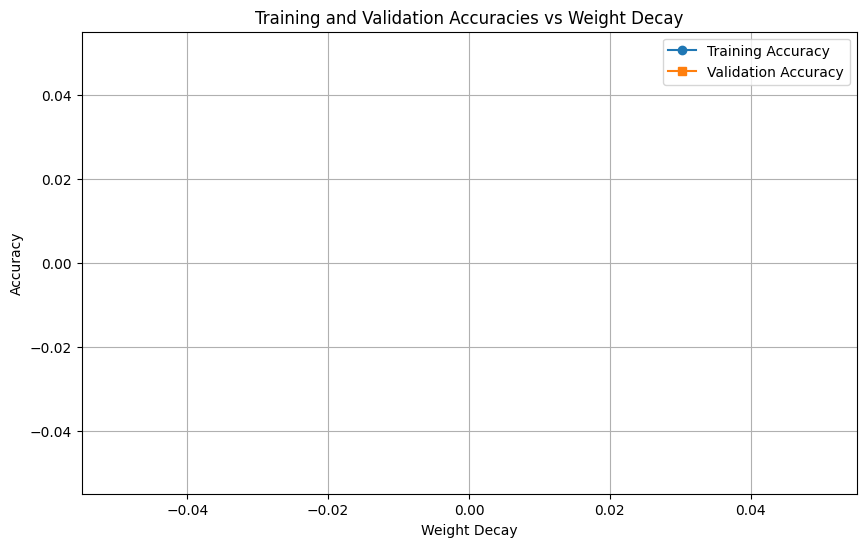

In [ ]:
import torch
import matplotlib.pyplot as plt
import os


# Weight decay values and corresponding .pt file names
file_names = {
    0: "res_none.pt",
    0.0001: "res_none_wd10e-04.pt",
    0.0005: "res_none_wd50e-04.pt",
    0.001: "res_none_wd10e-03.pt"
}

# Initialize lists to store accuracies
weight_decays = []
train_accuracies = []
val_accuracies = []

# Load each model and extract accuracies
for wd, file_name in file_names.items():
    file_path = os.path.join(results_dir, file_name)
    if os.path.exists(file_path):
        # Use weights_only=True for security
        checkpoint = torch.load(file_path, weights_only=True)
        train_acc = checkpoint.get('train_accuracy', None)
        val_acc = checkpoint.get('val_accuracy', None)

        if train_acc is not None and val_acc is not None:
            weight_decays.append(wd)
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
    else:
        print(f"File {file_path} does not exist.")

# Plotting the accuracies
plt.figure(figsize=(10, 6))

# Plot training accuracies
plt.plot(weight_decays, train_accuracies, 'o-', label='Training Accuracy')

# Plot validation accuracies
plt.plot(weight_decays, val_accuracies, 's-', label='Validation Accuracy')

# Add labels and title
plt.xlabel('Weight Decay')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies vs Weight Decay')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()